In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from pathlib import Path
import keras
from keras import layers
import matplotlib.pyplot as plt
import shutil
import random
import pathlib
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ruta_datos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Conjunto Completo.zip"
ruta_salida = "/content/"
!unzip -qq "{ruta_datos}" -d "{ruta_salida}"

In [ ]:
original_dir = pathlib.Path("/content/Conjunto Completo")
new_base_dir = pathlib.Path("/content/")
classes = ["A", "R", "S"]

train_split = 0.8
test_split = 0.2

for category in classes:
    print(f"Processing {category} images...")

    # Obtener los nombres de archivo para la categoría actual
    fnames = [fname for fname in os.listdir(original_dir) if fname.startswith(category)]

    # Obtener el número total de imágenes
    n_images = len(fnames)

    # Mezclar los nombres de archivo al azar
    random.shuffle(fnames)

    # Calcular el número de imágenes para cada conjunto
    n_train = int(train_split * n_images)
    n_test = int(test_split * n_images)

    # Dividir los nombres de archivo en conjuntos
    train_fnames = fnames[:n_train]
    test_fnames = fnames[n_train:n_train+n_test]

    # Crear los directorios para los conjuntos
    train_dir = new_base_dir / "train" / category
    test_dir = new_base_dir / "test" / category
    combined_dir = new_base_dir / "combined" / category

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    os.makedirs(combined_dir, exist_ok=True)

    # Copiar las imágenes a los directorios correspondientes
    for fname in train_fnames:
        src_path = original_dir / fname
        dst_path = train_dir / fname
        shutil.copyfile(src_path, dst_path)

    for fname in test_fnames:
        src_path = original_dir / fname
        dst_path = test_dir / fname
        shutil.copyfile(src_path, dst_path)

    # Copiar las imágenes de train y test a combined_dir
    combined_fnames = train_fnames + test_fnames
    for fname in combined_fnames:
        src_path = original_dir / fname
        dst_path = combined_dir / fname
        shutil.copyfile(src_path, dst_path)

print("Done.")


Processing A images...
Processing R images...
Processing S images...
Done.


In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(224, 224),
    batch_size=16)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(224, 224),
    batch_size=16,
    shuffle = False)
total_dataset = image_dataset_from_directory(
    new_base_dir / "combined",
    image_size = (224, 224),
    batch_size = 16
)

Found 534 files belonging to 3 classes.
Found 132 files belonging to 3 classes.
Found 666 files belonging to 3 classes.


In [ ]:
# Obtener los datos de entrenamiento y las etiquetas de entrenamiento
X_train = []
y_train = []
for images, labels in train_dataset:
    X_train.append(images.numpy())
    y_train.append(labels.numpy())

X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

# Obtener los datos de prueba y las etiquetas de prueba
X_test = []
y_test = []
for images, labels in test_dataset:
    X_test.append(images.numpy())
    y_test.append(labels.numpy())

X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

# Obtener los datos combinados y las etiquetas combinadas
X_combined = []
y_combined = []
for images, labels in total_dataset:
    X_combined.append(images.numpy())
    y_combined.append(labels.numpy())

X_combined = np.concatenate(X_combined)
y_combined = np.concatenate(y_combined)


In [ ]:
data_augmentation = keras.Sequential(
        [
            layers.RandomRotation(random.uniform(0, 0.2)),
            layers.RandomZoom(random.uniform(0.1, 0.3)),
            layers.RandomContrast(random.uniform(0.1, 0.3)),
            layers.RandomBrightness(random.uniform(0.1, 0.3)),
            layers.RandomTranslation(height_factor=random.uniform(0, 0.1),
                                      width_factor=random.uniform(0, 0.1)),
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
        ]
)

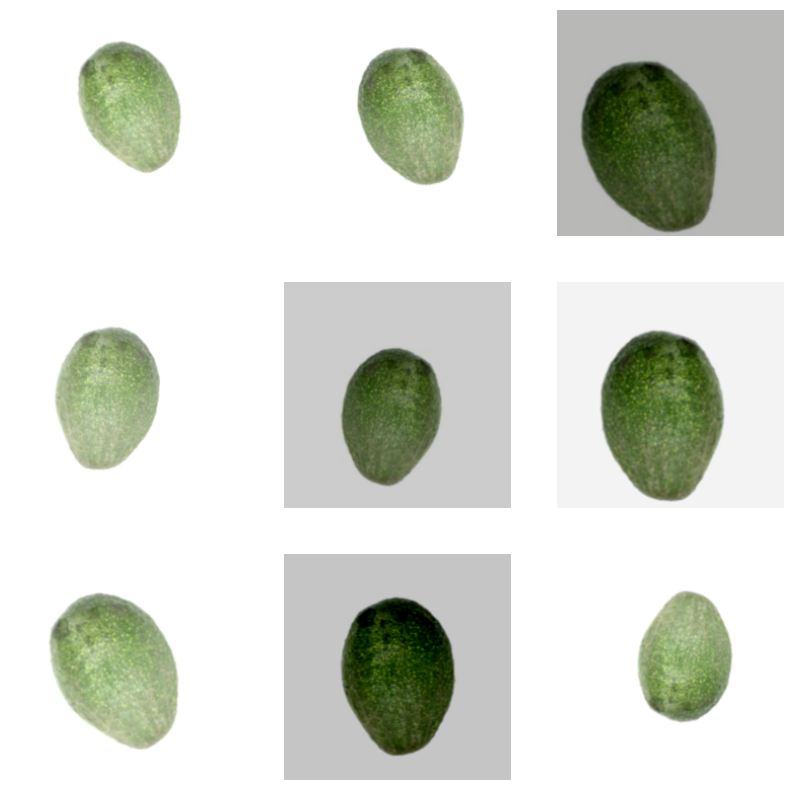

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print("labels batch shape", labels_batch.shape)
  break

data batch shape: (16, 224, 224, 3)
labels batch shape (16,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [ ]:
ruta_modelos = "/content/drive/MyDrive/Entrenamientos DL COA 690/Nuevos datos/Modelos optimizados/"
os.chdir(ruta_modelos)

modelo_entrenado = keras.models.load_model("MNV2.keras")

modelo_2 = Model(inputs=modelo_entrenado.input,outputs=modelo_entrenado.get_layer('dense').output)

features = modelo_entrenado.predict(X_train)

# Llamar al modelo de Random Forest

rf_model = RandomForestClassifier(random_state = 1)

17/17 [==============================] - 19s 993ms/step


In [ ]:
from sklearn.model_selection import GridSearchCV

# Se define un rango de valores para cada hiperparámetro de interés

estimator_range = [100, 200, 300, 1000]
max_depth_range = [4, 6, 8, 20]

param_grid = [{'n_estimators': estimator_range,
               'max_features': [ 'sqrt', 'auto'],
               'max_depth': max_depth_range,
               'criterion': ['gini', 'entropy']}]

gs = GridSearchCV(estimator = rf_model,
                  param_grid = param_grid,
                  scoring = 'accuracy',
                  cv = 10,
                  n_jobs = -1,
                  refit = True)

gs = gs.fit(features, y_train)
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 20,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [ ]:
pipe_rfc = make_pipeline(StandardScaler(),
                          RandomForestClassifier(criterion = 'entropy',
                          max_depth = 20,
                          max_features = 'sqrt',
                          n_estimators = 200,
                          n_jobs = -1,
                          random_state = 1))

In [ ]:
X_features = modelo_entrenado.predict(X_combined)

21/21 [==============================] - 23s 1s/step


Accuracy para el pliegue 0: 0.85 
Accuracy para el pliegue 1: 0.79 
Accuracy para el pliegue 2: 0.84 
Accuracy para el pliegue 3: 0.85 
Accuracy para el pliegue 4: 0.85 
Accuracy para el pliegue 5: 0.81 
Accuracy para el pliegue 6: 0.77 
Accuracy para el pliegue 7: 0.80 
Accuracy para el pliegue 8: 0.82 
Accuracy para el pliegue 9: 0.86 

Mejor pliegue: 9, Accuracy: 0.86
Desviación estándar: (+/-) 0.03

Métricas de desempeño para el mejor pliegue:
              precision    recall  f1-score   support

           0       0.92      0.61      0.73        18
           1       0.86      0.95      0.90        20
           2       0.84      0.96      0.90        28

    accuracy                           0.86        66
   macro avg       0.87      0.84      0.85        66
weighted avg       0.87      0.86      0.86        66



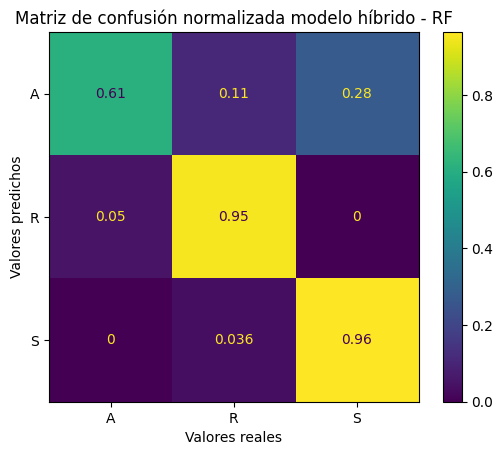

AUC para la clase 0: 0.80
AUC para la clase 1: 0.91
AUC para la clase 2: 0.93


In [ ]:
best_accuracy = 0
best_fold = 0
best_auc = 0.0
pliegues = []

# Obtiene las predicciones y el classification report para cada validación
for i, (train_index, test_index) in enumerate(StratifiedKFold(10).split(X_features, y_combined)):
    # Separa los datos en conjuntos de entrenamiento y prueba para la i-ésima validación
    X_train_cv, X_test_cv = X_features[train_index], X_features[test_index]
    y_train_cv, y_test_cv = y_combined[train_index], y_combined[test_index]

    # Entrena el modelo con los datos de entrenamiento
    pipe_rfc.fit(X_train_cv, y_train_cv)

    # Haz predicciones en los datos de prueba
    y_pred = pipe_rfc.predict(X_test_cv)

    # Haz predicciones y calcular la pertenencia para cada clase
    y_pred_proba = pipe_rfc.predict_proba(X_test_cv)

    # Calcula el accuracy para las predicciones
    accuracy = accuracy_score(y_test_cv, y_pred)

    # Calcula el AUC para las predicciones
    auc = roc_auc_score(y_test_cv, y_pred_proba, average = None, multi_class = 'ovr')

    # Actualiza el mejor fold si el accuracy actual es mayor que el anterior
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_fold = i
        best_report = metrics.classification_report(y_test_cv, y_pred)
        etiquetas = classes
        matriz_c = confusion_matrix(y_test_cv, y_pred,
                                    labels = pipe_rfc.classes_,
                                    normalize = 'true' )
        display = ConfusionMatrixDisplay(confusion_matrix = matriz_c,
                                 display_labels = etiquetas)
        best_auc = auc


    # Imprime el accuracy para la i-ésima validación
    print("Accuracy para el pliegue %d: %0.2f " % (i, accuracy))

    #Guardar los ACC de cada pliegue
    pliegues.append(accuracy)

# Imprime el fold con el mejor accuracy
print("\nMejor pliegue: %d, Accuracy: %0.2f" % (best_fold, best_accuracy))
print("Desviación estándar: (+/-) %0.2f" % np.std(pliegues))

# Imprime el classification report para el mejor fold
print("\nMétricas de desempeño para el mejor pliegue:")
print(best_report)

fig, ax = plt.subplots()
display.plot(ax=ax)
ax.set_title("Matriz de confusión normalizada modelo híbrido - RF")
ax.set_xlabel("Valores reales")
ax.set_ylabel("Valores predichos")
plt.show()

# Imprime el AUC para cada clase en el mejor fold
for clase, auc_score in zip(pipe_rfc.classes_, best_auc):
    auc_formatted = "{:.2f}".format(auc_score)
    print(f"AUC para la clase {clase}: {auc_formatted}")
